# DATA

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


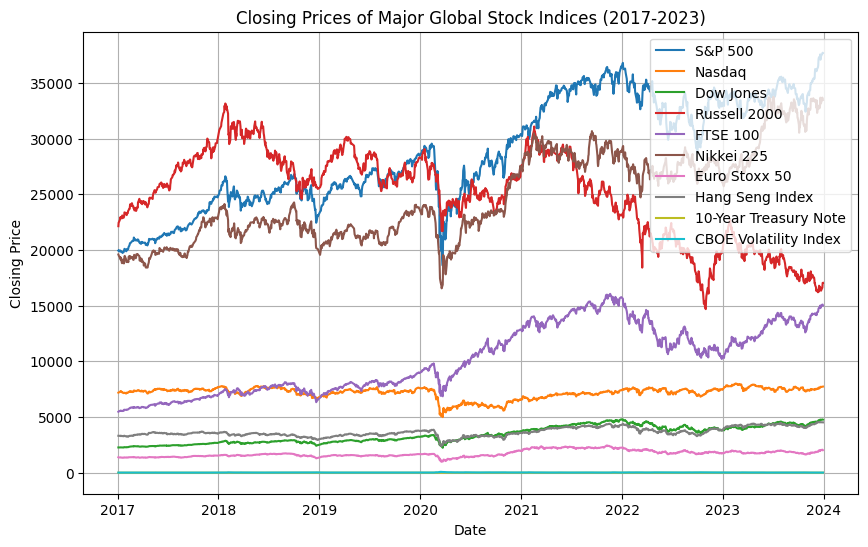

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  

# List of stock indices with correct symbols for Yahoo Finance
indices = ['^GSPC', '^IXIC', '^DJI', '^RUT', '^FTSE', '^N225', 
           '^STOXX50E', '^HSI', '^TNX', '^VIX']

# Periods of interest
start_date_pre_covid = '2017-01-01'
end_date_pre_covid = '2019-12-31'

start_date_covid = '2020-01-01'
end_date_covid = '2021-12-31'

start_date_post_covid = '2022-01-01'
end_date_post_covid = '2023-12-31'

# Function to download closing price data
def download_data(indices, start_date, end_date):
    data = yf.download(indices, start=start_date, end=end_date)['Close']
    return data

# Download the data
data_pre_covid = download_data(indices, start_date_pre_covid, end_date_pre_covid)
data_covid = download_data(indices, start_date_covid, end_date_covid)
data_post_covid = download_data(indices, start_date_post_covid, end_date_post_covid)

# Combine the data
data_combined = pd.concat([data_pre_covid, data_covid, data_post_covid], axis=0)

# Adjust the data (optional, e.g., removing NaN or normalizing)
data_combined = data_combined.dropna()  # Remove any NaN values

# Plot the data
plt.figure(figsize=(10, 6))
for col in data_combined.columns:
    plt.plot(data_combined.index, data_combined[col], label=col)
plt.title('Closing Prices of Major Global Stock Indices (2017-2023)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(labels=['S&P 500', 'Nasdaq', 'Dow Jones', 'Russell 2000', 'FTSE 100', 'Nikkei 225', 
                   'Euro Stoxx 50', 'Hang Seng Index', '10-Year Treasury Note', 'CBOE Volatility Index'])
plt.grid(True)
plt.show()

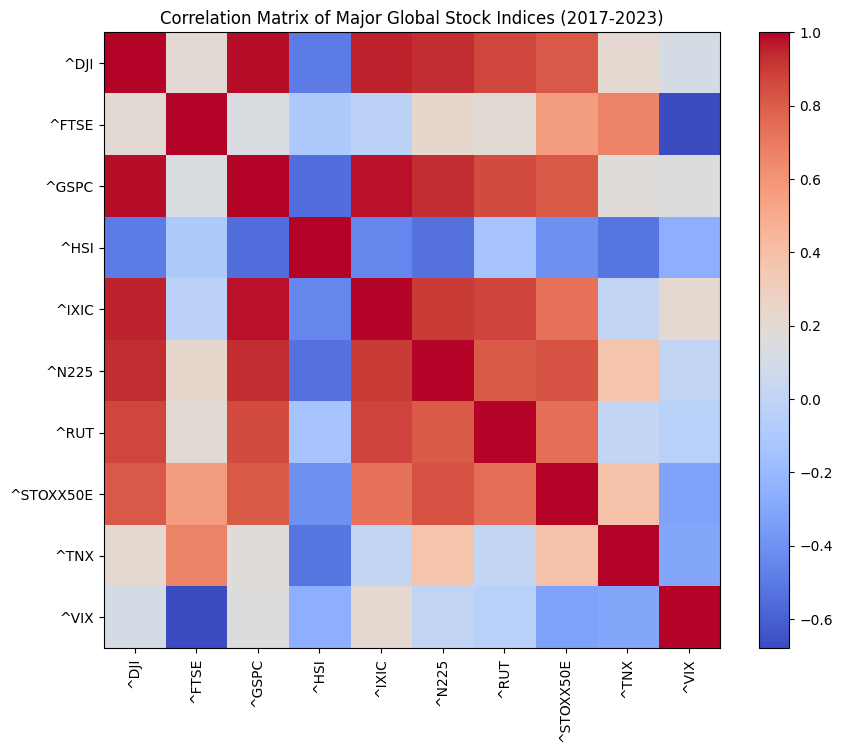

Ticker         ^DJI     ^FTSE     ^GSPC      ^HSI     ^IXIC     ^N225  \
Ticker                                                                  
^DJI       1.000000  0.193804  0.984981 -0.489722  0.948682  0.928373   
^FTSE      0.193804  1.000000  0.135053 -0.100953 -0.026527  0.234214   
^GSPC      0.984981  0.135053  1.000000 -0.546546  0.977173  0.932641   
^HSI      -0.489722 -0.100953 -0.546546  1.000000 -0.448015 -0.532517   
^IXIC      0.948682 -0.026527  0.977173 -0.448015  1.000000  0.900686   
^N225      0.928373  0.234214  0.932641 -0.532517  0.900686  1.000000   
^RUT       0.866704  0.196988  0.854497 -0.141209  0.872001  0.807616   
^STOXX50E  0.810425  0.564637  0.804014 -0.406679  0.730467  0.834020   
^TNX       0.211419  0.670160  0.176226 -0.521563  0.009696  0.367293   
^VIX       0.109098 -0.679157  0.155619 -0.256669  0.214175  0.008381   

Ticker         ^RUT  ^STOXX50E      ^TNX      ^VIX  
Ticker                                              
^DJI       0.8667

In [19]:
# Calculate the correlation matrix
correlation_matrix = data_combined.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix of Major Global Stock Indices (2017-2023)')
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

# Optionally, print the correlation matrix
print(correlation_matrix)

# MODEL

In [8]:
import numpy as np
import tvgl

data = data_combined.values

# set parameters
alpha = 10
beta = 10
penalty_type = "L2"
slice_size = 50

# run TVGL
model = tvgl.TVGL(alpha, beta, penalty_type, slice_size)
model.fit(data)

# PRECISION MATRICES

Diff before and during COVID: 1.690428015481759
Diff during and after COVID: 2.022270342882381


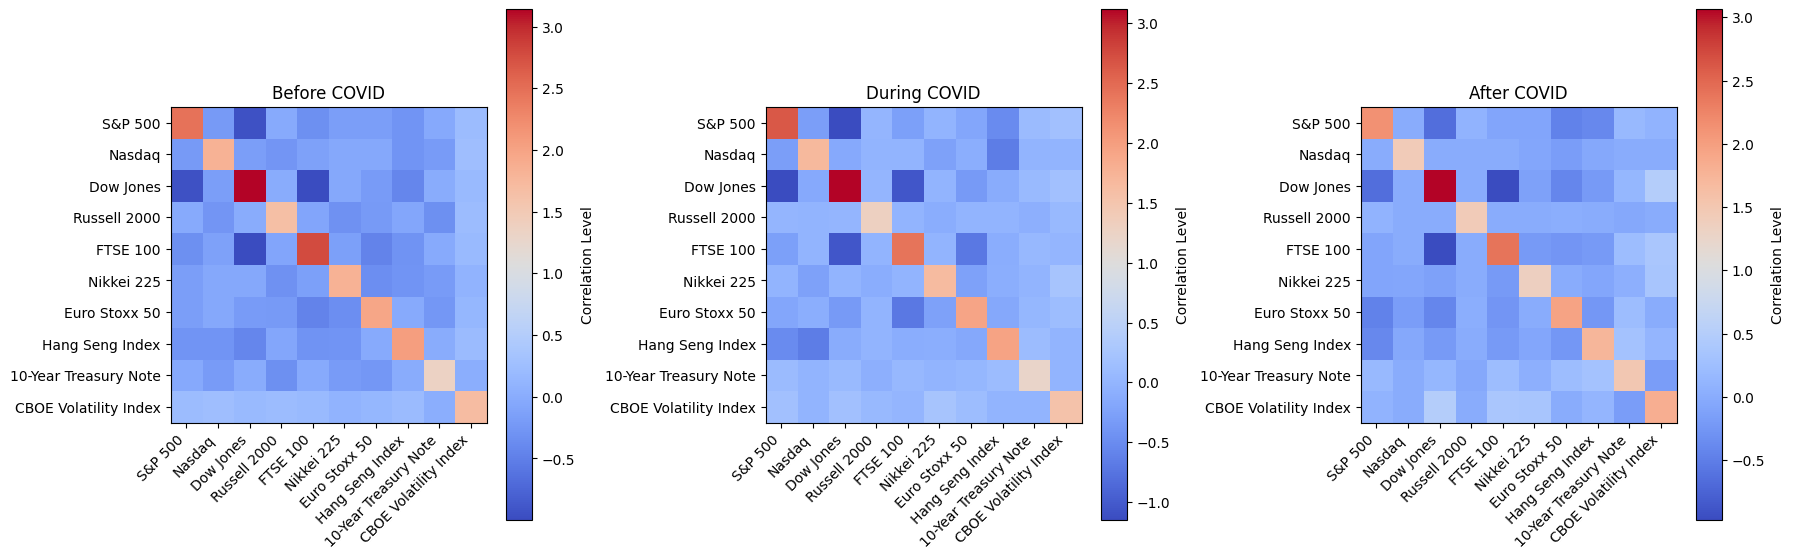

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tvgl

# Load the data
data = data_combined.values

# Assume you have a list with the names of the indices
index_names = ['S&P 500', 'Nasdaq', 'Dow Jones', 'Russell 2000', 'FTSE 100', 'Nikkei 225', 
               'Euro Stoxx 50', 'Hang Seng Index', '10-Year Treasury Note', 'CBOE Volatility Index']

# Define the periods (before, during, and after COVID)
before_covid = data[:int(len(data)*0.4)]  # 40% before COVID
during_covid = data[int(len(data)*0.4):int(len(data)*0.8)]  # 40% during COVID
after_covid = data[int(len(data)*0.8):]  # 20% after COVID

# Set the parameters for TVGL
alpha = 10
beta = 10
penalty_type = "L2"
slice_size = 50

# Create the TVGL model
model_before = tvgl.TVGL(alpha, beta, penalty_type, slice_size)
model_during = tvgl.TVGL(alpha, beta, penalty_type, slice_size)
model_after = tvgl.TVGL(alpha, beta, penalty_type, slice_size)

# Train the models on their respective data
model_before.fit(before_covid)
model_during.fit(during_covid)
model_after.fit(after_covid)

# Compare the precision matrices across periods
precision_before = model_before.precision_set
precision_during = model_during.precision_set
precision_after = model_after.precision_set

# Compute the difference between precision matrices
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Calculate the Frobenius norm difference for each period
diff_before_during = frobenius_norm(precision_before[-1], precision_during[-1])
diff_during_after = frobenius_norm(precision_during[-1], precision_after[-1])

print(f"Diff before and during COVID: {diff_before_during}")
print(f"Diff during and after COVID: {diff_during_after}")

# Visualize the graphs for each period
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot the graph
def plot_graph(matrix, ax, title):
    cax = ax.imshow(matrix, cmap='coolwarm', interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(range(len(matrix)))
    ax.set_yticks(range(len(matrix)))
    
    # Use index names as labels on the axes
    ax.set_xticklabels(index_names, rotation=45, ha="right")
    ax.set_yticklabels(index_names)
    
    # Add a colorbar to explain the color scale
    cbar = plt.colorbar(cax, ax=ax)
    cbar.set_label('Correlation Level')

# Plot the precision matrix for the three periods
plot_graph(precision_before[-1], axes[0], "Before COVID")
plot_graph(precision_during[-1], axes[1], "During COVID")
plot_graph(precision_after[-1], axes[2], "After COVID")

plt.tight_layout()
plt.show()

# GRAPH

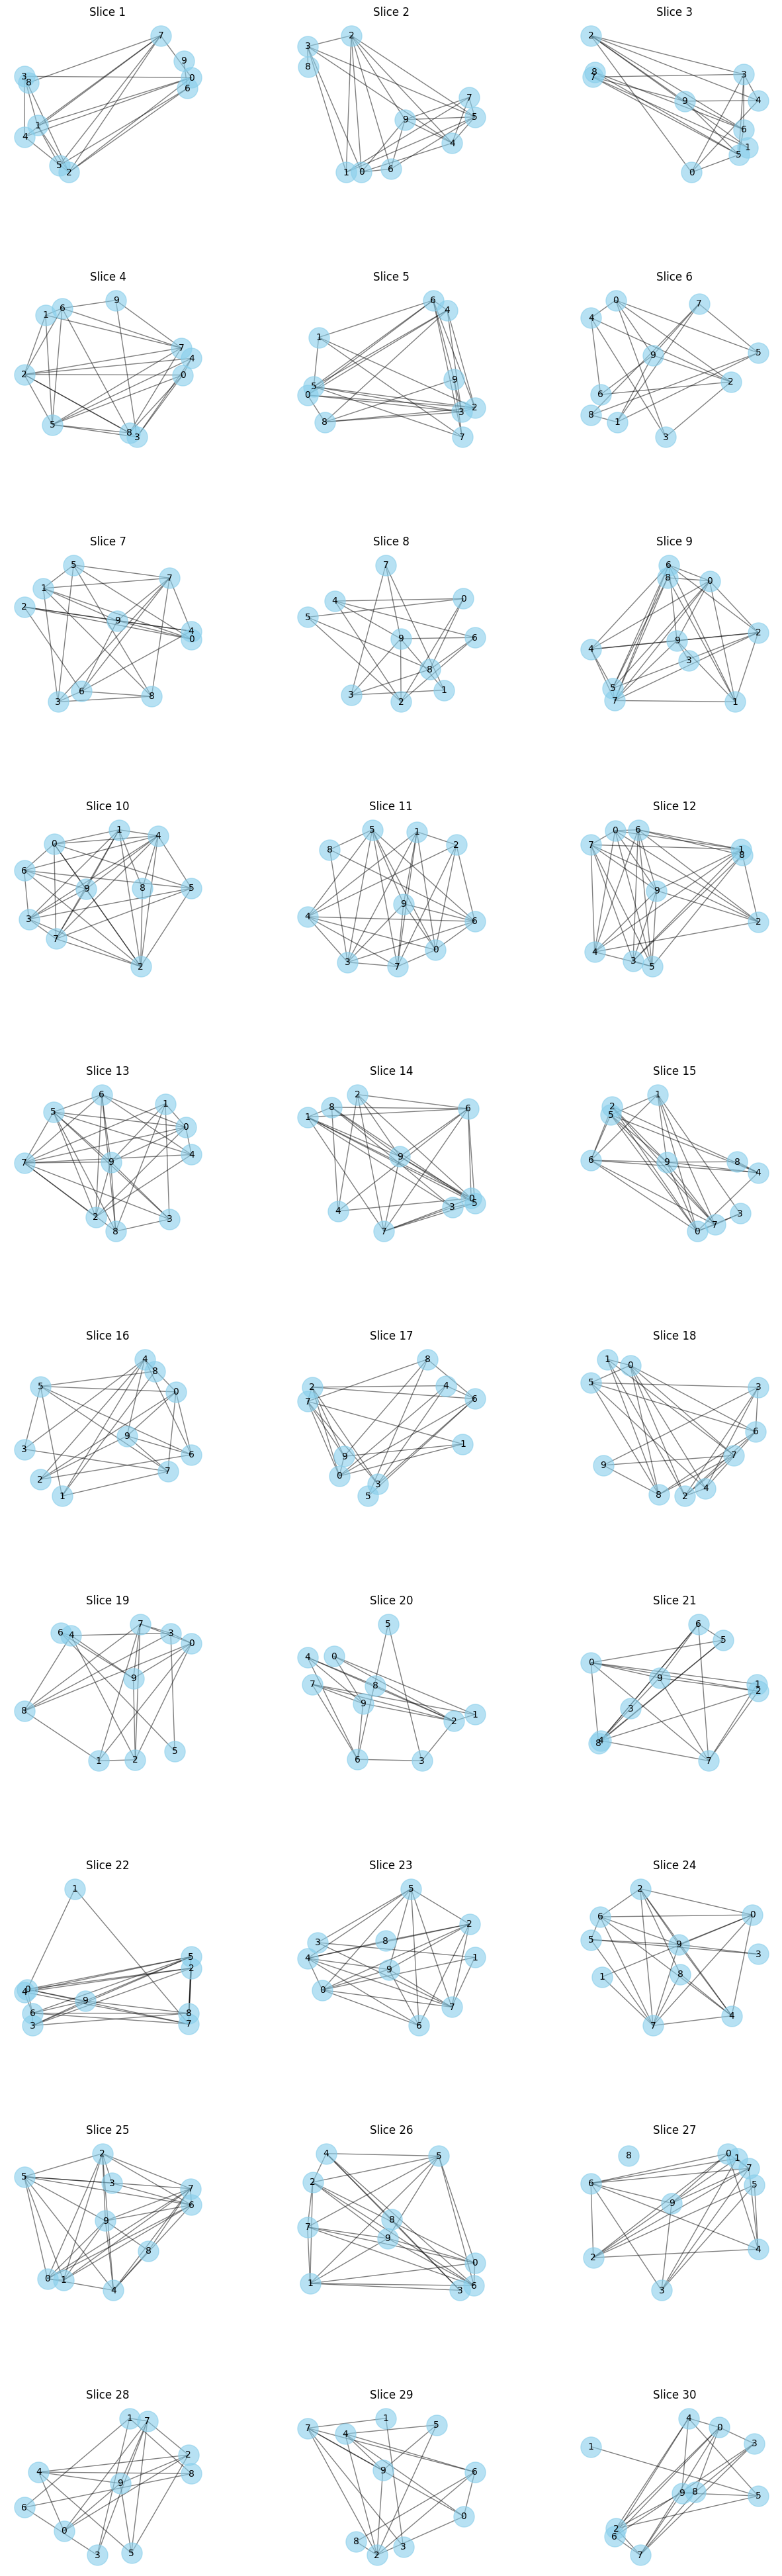

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tvgl
import networkx as nx

# Function to create a graph from a precision matrix
def plot_network(precision_matrix, ax, title, threshold=0.1):
    # Remove self-correlation (set diagonal to 0)
    np.fill_diagonal(precision_matrix, 0)

    # Create the graph
    G = nx.from_numpy_array(precision_matrix)  # Changed from from_numpy_matrix to from_numpy_array

    # Remove edges below the threshold
    for (i, j, weight) in list(G.edges(data=True)):
        if abs(weight['weight']) < threshold:  # Threshold for significant connection
            G.remove_edge(i, j)

    # Draw the graph
    pos = nx.spring_layout(G)  # Graph layout
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color='skyblue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, ax=ax, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10, font_color='black')

    ax.set_title(title)
    ax.axis('off')

# Layout parameters
num_slices = len(model.precision_set)
rows = int(np.ceil(num_slices / 3))  # 3 graphs per row
cols = min(3, num_slices)  # Maximum 3 columns
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Height increases with rows

# If we have a grid, 'axes' is a 2D array; flatten it for easier access
axes = axes.flatten() if rows > 1 else [axes]

# Plot each time slice as a network graph
threshold = 0.1  # Threshold for significant connection
for idx, precision_matrix in enumerate(model.precision_set):
    plot_network(precision_matrix, axes[idx], f"Slice {idx + 1}", threshold)

# Disable unused axes (if there are more subplots than needed)
for ax in axes[num_slices:]:
    ax.axis("off")

# Adjust spaces between the graphs
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

# BEFORE, DURING AND AFTER CODIV

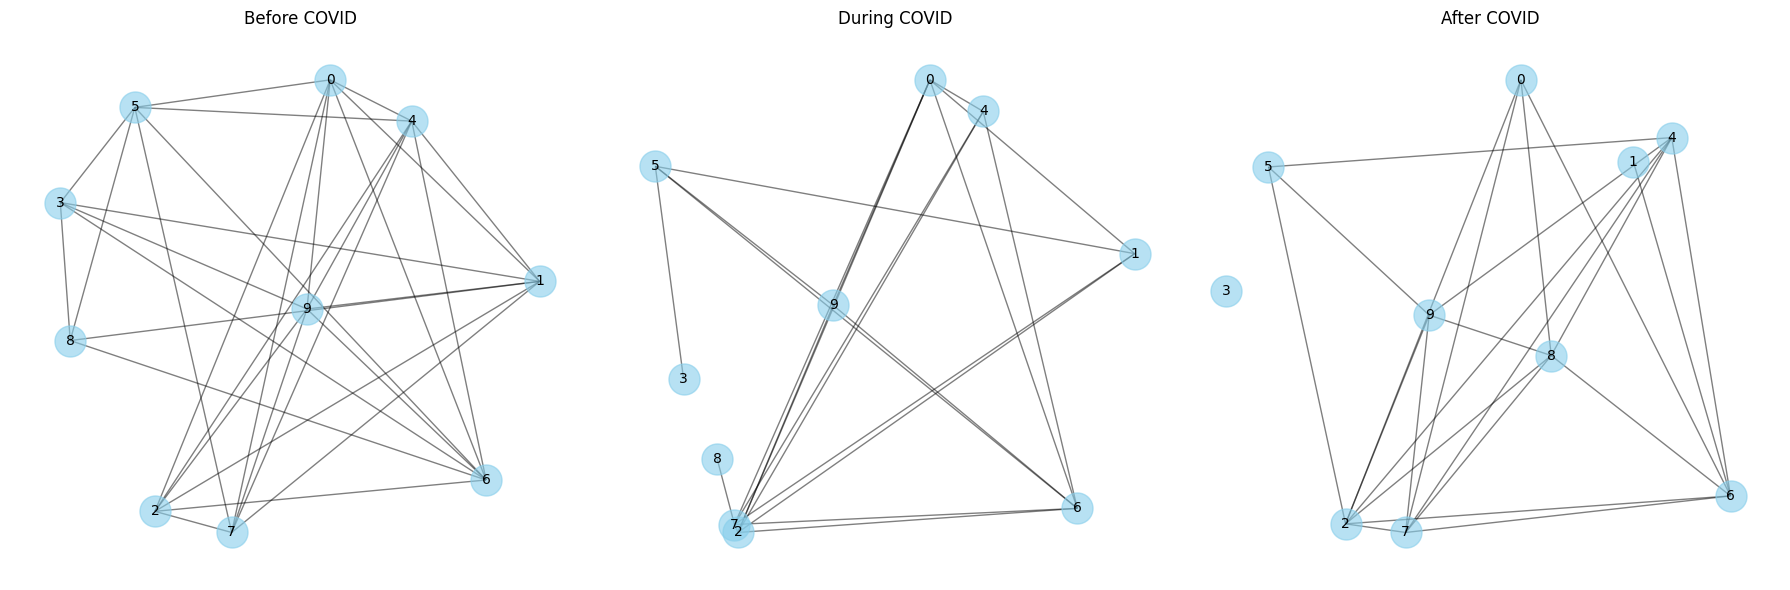

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tvgl
import networkx as nx

# Function to create a graph from a precision matrix
def plot_network(precision_matrix, ax, title, threshold=0.1):
    # Remove self-correlation (set diagonal to 0)
    np.fill_diagonal(precision_matrix, 0)

    # Create the graph
    G = nx.from_numpy_array(precision_matrix)

    # Remove edges below the threshold
    for (i, j, weight) in list(G.edges(data=True)):
        if abs(weight['weight']) < threshold:  # Threshold for significant connection
            G.remove_edge(i, j)

    # Draw the graph
    pos = nx.spring_layout(G, seed=42)  # Graph layout with a seed for repeatable results
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color='skyblue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, ax=ax, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10, font_color='black')

    ax.set_title(title)
    ax.axis('off')

# Precision matrices for the three periods (assuming they are already calculated)
precision_before_covid = model_before.precision_set[-1]  # Before COVID
precision_during_covid = model_during.precision_set[-1]  # During COVID
precision_after_covid = model_after.precision_set[-1]    # After COVID

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the graphs for each period
plot_network(precision_before_covid, axes[0], "Before COVID", threshold=0.1)
plot_network(precision_during_covid, axes[1], "During COVID", threshold=0.1)
plot_network(precision_after_covid, axes[2], "After COVID", threshold=0.1)

# Adjust the spacing between the graphs
plt.tight_layout()
plt.show()

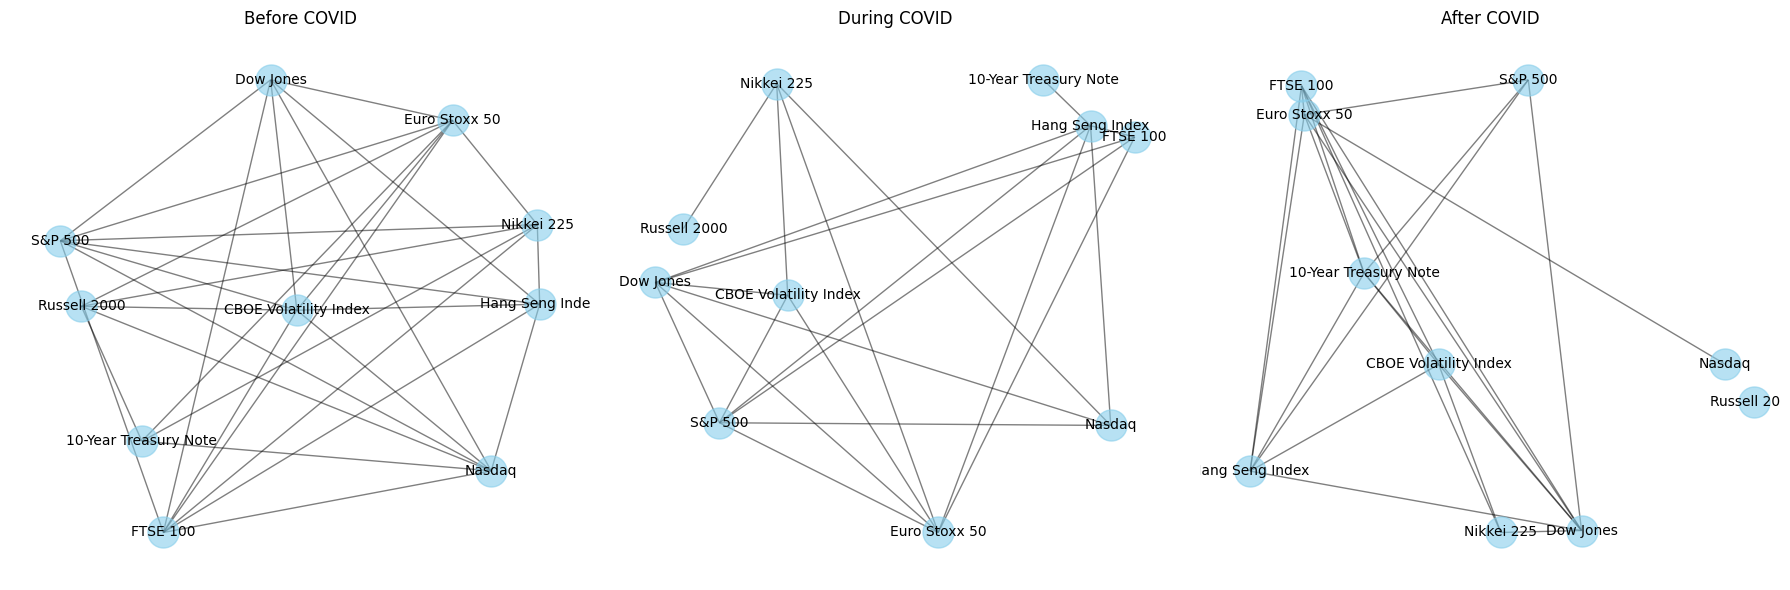

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tvgl
import networkx as nx

# Function to create a graph from a precision matrix
def plot_network(precision_matrix, ax, title, index_names, threshold=0.1):
    # Create the graph
    G = nx.from_numpy_array(precision_matrix)  # Create graph from precision matrix

    # Remove edges below the threshold
    for (i, j, weight) in list(G.edges(data=True)):
        if abs(weight['weight']) < threshold:  # Threshold for significant connection
            G.remove_edge(i, j)

    # Draw the graph
    pos = nx.spring_layout(G)  # Graph layout
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color='skyblue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, ax=ax, width=1.0, alpha=0.5)
    
    # Use index names as labels for nodes
    labels = {i: index_names[i] for i in range(len(index_names))}
    nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, font_size=10, font_color='black')

    ax.set_title(title)
    ax.axis('off')

# Example list of index names
index_names = ['S&P 500', 'Nasdaq', 'Dow Jones', 'Russell 2000', 'FTSE 100', 'Nikkei 225', 
               'Euro Stoxx 50', 'Hang Seng Index', '10-Year Treasury Note', 'CBOE Volatility Index']

# Assuming you have the precision matrices for the three periods (before, during, after COVID)
precision_before_covid = model_before.precision_set[-1]  # Before COVID
precision_during_covid = model_during.precision_set[-1]  # During COVID
precision_after_covid = model_after.precision_set[-1]    # After COVID

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the graphs for each period with named nodes
plot_network(precision_before_covid, axes[0], "Before COVID", index_names, threshold=0.1)
plot_network(precision_during_covid, axes[1], "During COVID", index_names, threshold=0.1)
plot_network(precision_after_covid, axes[2], "After COVID", index_names, threshold=0.1)

# Adjust the spacing between the graphs
plt.tight_layout()
plt.show()

# Bayesian Optimization

In [160]:
import optuna
import numpy as np
import tvgl

# Function to calculate the Frobenius norm
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Function to calculate the score for a given set of parameters
def objective(trial, data):
    # Get the alpha and beta parameters from the trial
    alpha = trial.suggest_int('alpha', 1, 20)  # Alpha between 1 and 20
    beta = trial.suggest_int('beta', 1, 20)    # Beta between 1 and 20
    
    # Set up the TVGL model
    model = tvgl.TVGL(alpha, beta, penalty_type="L2", slice_size=50)
    model.fit(data)
    
    # Calculate the precision matrix for the last slice
    precision_matrix_test = model.precision_set[-1]
    avg_precision_matrix = np.mean(model.precision_set, axis=0)
    
    # Calculate the score using the Frobenius norm
    score = frobenius_norm(precision_matrix_test, avg_precision_matrix)
    return score

# Bayesian optimization function
def optimize_hyperparameters(data):
    # Create an Optuna study
    study = optuna.create_study(direction='minimize')  # Minimize the objective function
    study.optimize(lambda trial: objective(trial, data), n_trials=10)  # 10 trials
    
    # Return the best parameters and score
    best_alpha = study.best_params['alpha']
    best_beta = study.best_params['beta']
    best_score = study.best_value
    
    return best_alpha, best_beta, best_score

# Perform Bayesian optimization on your data
best_alpha, best_beta, best_score = optimize_hyperparameters(data_combined.values)

print(f"Best Alpha: {best_alpha}, Best Beta: {best_beta}, Best Score: {best_score}")

[I 2025-01-24 15:45:59,948] A new study created in memory with name: no-name-21a654f0-ae29-4025-97dc-351cf061b63d


[I 2025-01-24 15:46:16,189] Trial 0 finished with value: 2.148912179130937 and parameters: {'alpha': 7, 'beta': 8}. Best is trial 0 with value: 2.148912179130937.
[I 2025-01-24 15:46:51,070] Trial 1 finished with value: 2.0021182091211203 and parameters: {'alpha': 6, 'beta': 16}. Best is trial 1 with value: 2.0021182091211203.
[I 2025-01-24 15:47:15,320] Trial 2 finished with value: 3.0707113472400476 and parameters: {'alpha': 3, 'beta': 7}. Best is trial 1 with value: 2.0021182091211203.
[I 2025-01-24 15:47:32,478] Trial 3 finished with value: 1.2830776219011468 and parameters: {'alpha': 14, 'beta': 18}. Best is trial 3 with value: 1.2830776219011468.
[I 2025-01-24 15:47:46,358] Trial 4 finished with value: 1.0539379025636706 and parameters: {'alpha': 18, 'beta': 12}. Best is trial 4 with value: 1.0539379025636706.
[I 2025-01-24 15:48:20,042] Trial 5 finished with value: 2.0021182091211203 and parameters: {'alpha': 6, 'beta': 16}. Best is trial 4 with value: 1.0539379025636706.
[I 202

Best Alpha: 18, Best Beta: 12, Best Score: 1.0539379025636706


# NEW PARAMETERS

Diff before and during COVID: 1.13410580620862
Diff during and after COVID: 1.2216334978295285


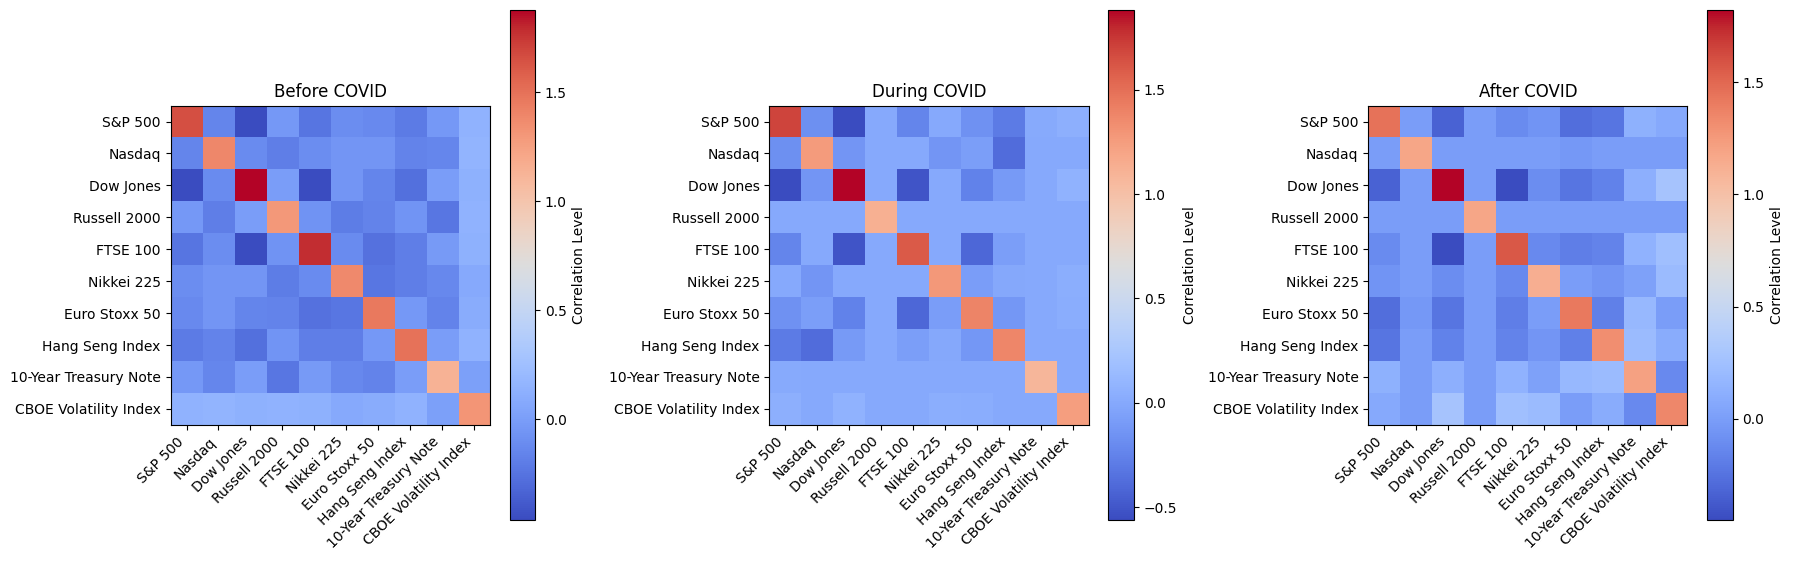

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import tvgl

# Load the data
data = data_combined.values

# Assume you have a list with the names of the indices
index_names = ['S&P 500', 'Nasdaq', 'Dow Jones', 'Russell 2000', 'FTSE 100', 'Nikkei 225', 
               'Euro Stoxx 50', 'Hang Seng Index', '10-Year Treasury Note', 'CBOE Volatility Index']

# Define the periods (before, during, and after COVID)
before_covid = data[:int(len(data)*0.4)]  # 40% before COVID
during_covid = data[int(len(data)*0.4):int(len(data)*0.8)]  # 40% during COVID
after_covid = data[int(len(data)*0.8):]  # 20% after COVID

# Set the parameters for TVGL
alpha = 18
beta = 12
penalty_type = "L2"
slice_size = 50

# Create the TVGL model
model_before = tvgl.TVGL(alpha, beta, penalty_type, slice_size)
model_during = tvgl.TVGL(alpha, beta, penalty_type, slice_size)
model_after = tvgl.TVGL(alpha, beta, penalty_type, slice_size)

# Train the models on their respective data
model_before.fit(before_covid)
model_during.fit(during_covid)
model_after.fit(after_covid)

# Compare the precision matrices across periods
precision_before = model_before.precision_set
precision_during = model_during.precision_set
precision_after = model_after.precision_set

# Compute the difference between precision matrices
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Calculate the Frobenius norm difference for each period
diff_before_during = frobenius_norm(precision_before[-1], precision_during[-1])
diff_during_after = frobenius_norm(precision_during[-1], precision_after[-1])

print(f"Diff before and during COVID: {diff_before_during}")
print(f"Diff during and after COVID: {diff_during_after}")

# Visualize the graphs for each period
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot the graph
def plot_graph(matrix, ax, title):
    cax = ax.imshow(matrix, cmap='coolwarm', interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(range(len(matrix)))
    ax.set_yticks(range(len(matrix)))
    
    # Use index names as labels on the axes
    ax.set_xticklabels(index_names, rotation=45, ha="right")
    ax.set_yticklabels(index_names)
    
    # Add a colorbar to explain the color scale
    cbar = plt.colorbar(cax, ax=ax)
    cbar.set_label('Correlation Level')

# Plot the precision matrix for the three periods
plot_graph(precision_before[-1], axes[0], "Before COVID")
plot_graph(precision_during[-1], axes[1], "During COVID")
plot_graph(precision_after[-1], axes[2], "After COVID")

plt.tight_layout()
plt.show()

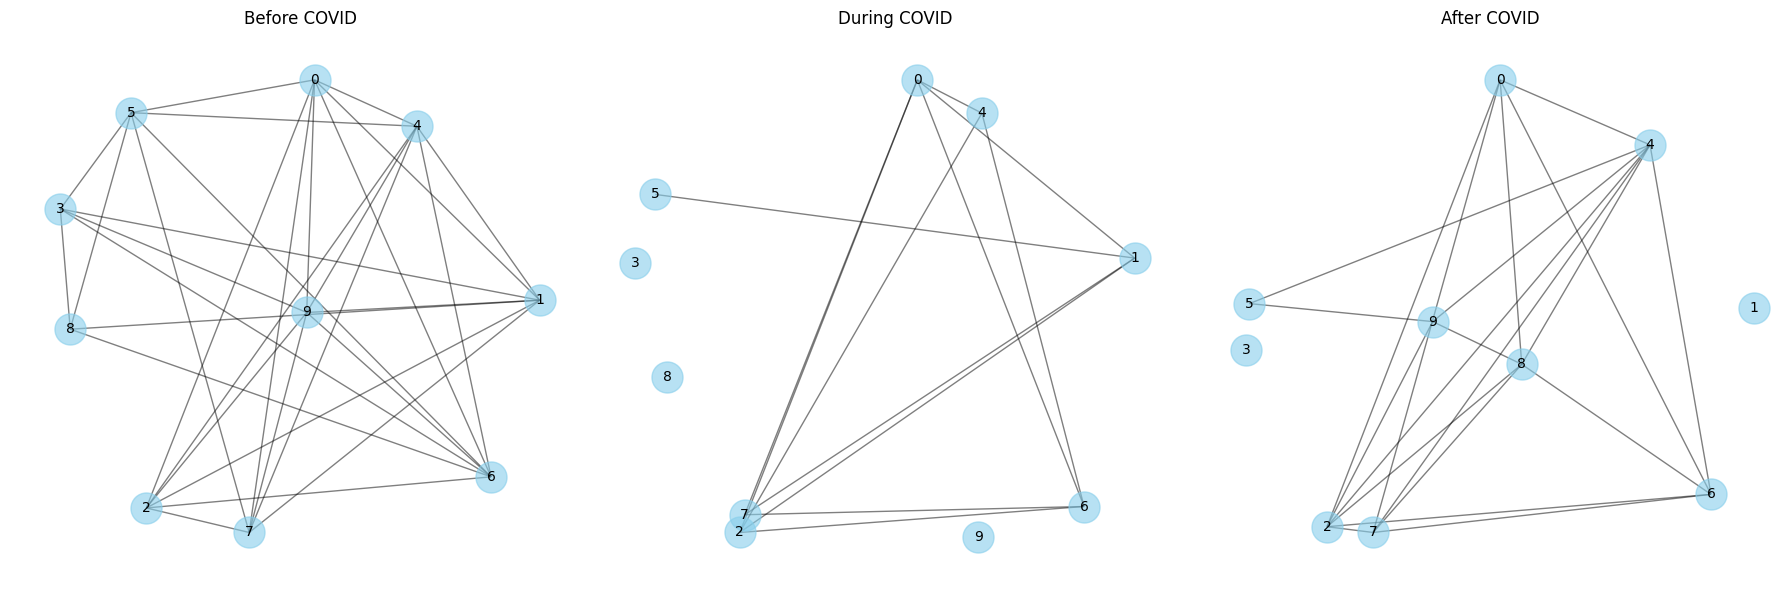

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import tvgl
import networkx as nx

# Function to create a graph from a precision matrix
def plot_network(precision_matrix, ax, title, threshold=0.1):
    # Remove self-correlation (set diagonal to 0)
    np.fill_diagonal(precision_matrix, 0)

    # Create the graph
    G = nx.from_numpy_array(precision_matrix)

    # Remove edges below the threshold
    for (i, j, weight) in list(G.edges(data=True)):
        if abs(weight['weight']) < threshold:  # Threshold for significant connection
            G.remove_edge(i, j)

    # Draw the graph
    pos = nx.spring_layout(G, seed=42)  # Graph layout with a seed for repeatable results
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color='skyblue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, ax=ax, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10, font_color='black')

    ax.set_title(title)
    ax.axis('off')

# Precision matrices for the three periods (assuming they are already calculated)
precision_before_covid = model_before.precision_set[-1]  # Before COVID
precision_during_covid = model_during.precision_set[-1]  # During COVID
precision_after_covid = model_after.precision_set[-1]    # After COVID

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the graphs for each period
plot_network(precision_before_covid, axes[0], "Before COVID", threshold=0.1)
plot_network(precision_during_covid, axes[1], "During COVID", threshold=0.1)
plot_network(precision_after_covid, axes[2], "After COVID", threshold=0.1)

# Adjust the spacing between the graphs
plt.tight_layout()
plt.show()